# Autocorrelation
The correlation of a signal with a delayed copy of itself as a function of delay.
# Noise
In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. 
# Lesson 1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

#SEASON PATTERN
def seasonal_pattern(season_time):
  return np.where(season_time<0.4, np.cos(season_time * 2 * np.pi), 1/np.exp(3 * season_time))
def seasonality(time, period, amplitude = 1, phase = 0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

#NOISE
def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.random(len(time)) * noise_level

#2 different AUTOCORRELATION
def autocorrelation1(time, amplitude, seed = None):
  rnd = np.random.RandomState(seed)
  phi1 = 0.5
  phi2 = -0.1
  ar = rnd.randn(len(time) + 50)
  ar[:50] = 100
  for step in range(50, len(time) + 50):
    ar[step] += phi1 * ar[step - 50]
    ar[step] += phi2 * ar[step - 33]
  return ar[50:] * amplitude

def autocorrelation2(time, amplitude, seed = None):
  rnd = np.random.RandomState(seed)
  phi = 0.8
  ar = rnd.randn(len(time) + 1)
  for step in range(1, len(time) + 1):
    ar[step] += phi * ar[step - 1]
  return ar[1:] * amplitude

#Impulses
def impulses(time, num_impulses, amplitude = 1, seed =None):
  rnd = np.random.RandomState(seed)
  impulse_indices = rnd.randint(len(time), size = 10)
  series = np.zeros(len(time))
  for index in impulse_indices:
    series[index] += rnd.rand() + amplitude
  return series

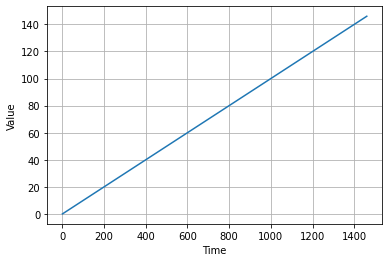

In [ ]:
time = np.arange(4 * 365 + 1)
#Simple linear Time series data :Let's create a time series that just trends upward:
baseline = 10
series = trend(time, 0.1)
plot_series(time, series)
plt.show()

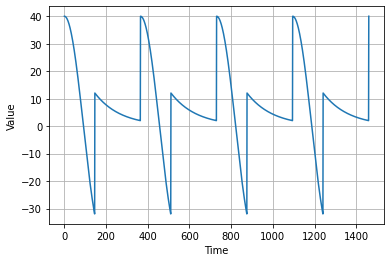

In [ ]:
#Now let's generate a time series with a seasonal pattern:
baseline = 10
amplitude = 40
series = seasonality(time, period = 365, amplitude=amplitude)
plot_series(time, series)
plt.show()

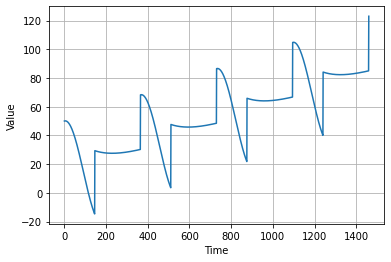

In [ ]:
#Now let's create a time series with both trend and seasonality:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude=amplitude)
plot_series(time, series)
plt.show()

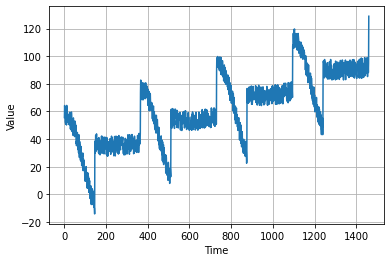

In [ ]:
#Let's generate some white noise:
noise_level = 15
noisy_series = series + noise(time, noise_level, seed = 42)
plot_series(time, noisy_series)
plt.show()

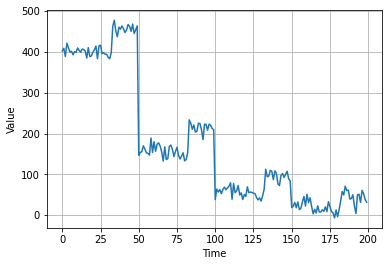

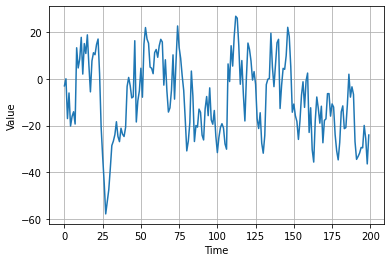

In [ ]:
series = autocorrelation1(time, 10, seed = 12)
plot_series(time[:200], series[:200])
plt.show()
series = autocorrelation2(time, 10, seed = 12)
plot_series(time[:200], series[:200])
plt.show()

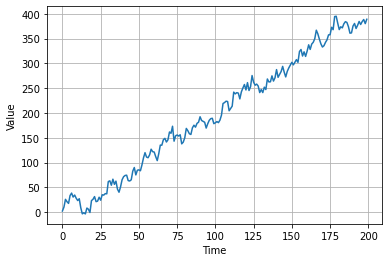

In [ ]:
#Another series
series = autocorrelation2(time, 10, seed = 42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

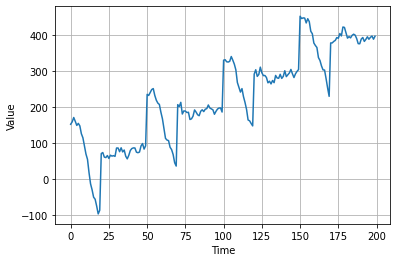

In [ ]:
#And Another series
series = autocorrelation2(time, 10, seed = 42) + seasonality(time, period= 50, amplitude=150) +trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

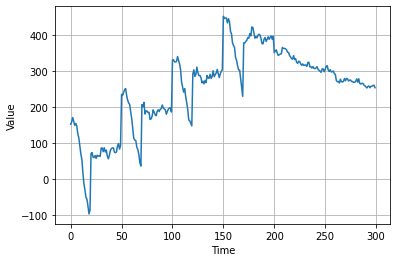

In [ ]:
#Seasonal Time series
series = autocorrelation2(time, 10, seed = 42) + seasonality(time, period= 50, amplitude=150) +trend(time, 2)
series2 = autocorrelation2(time, 5, seed = 42) + seasonality(time, period= 50, amplitude=2) +trend(time, -1) + 550
series[200:] = series2[200:]
plot_series(time[:300], series[:300])
plt.show()

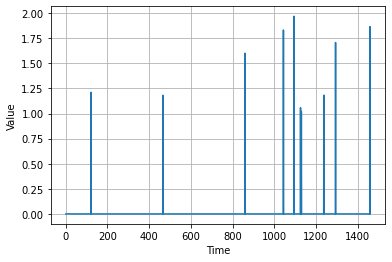

In [ ]:
#Trend Seasonality
series = impulses(time, 10, seed =42)
plot_series(time, series)
plt.show()

In [ ]:
def autocorrelation(source,phis):
  ar = source.copy()
  max_lag = len(phis)
  for step, value in enumerate(source):
    for lag, phi in phis.items():
      if step - lag > 0:
        ar[step] += phi * ar[step - lag]
  return ar

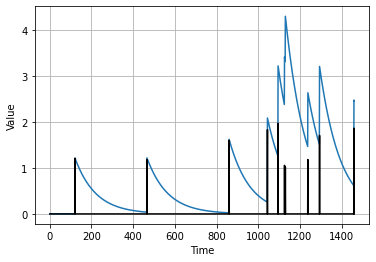

In [ ]:
signal = impulses(time, 10, seed = 42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

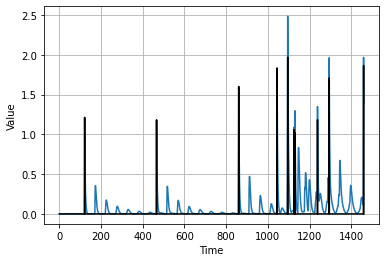

In [ ]:
signal = impulses(time, 10, seed = 42)
series = autocorrelation(signal, {1: 0.70, 50:0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

# Lesson 2
Simple Mathematical approach for prediction on the current data

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

2.4.1


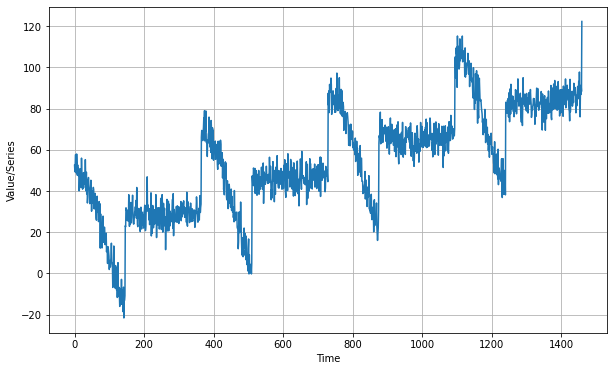

In [5]:
#Seasonality, trend, and bit of noise
def plot_series(time, series, format = "-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value/Series")
  plt.grid(True)
'''
slope = y/x
'''
def trend(time, slope = 0):
  return slope * time
#arbitrary pattern
def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1/np.exp(3 * season_time))
#repeat same pattern over a period
def seasonality(time, period, amplitude = 1, phase = 0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)
#noise
def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level
'''Featuers'''
time = np.arange(4 * 365 + 1, dtype="float32") #4 years
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

let's split it so we can start forecasting

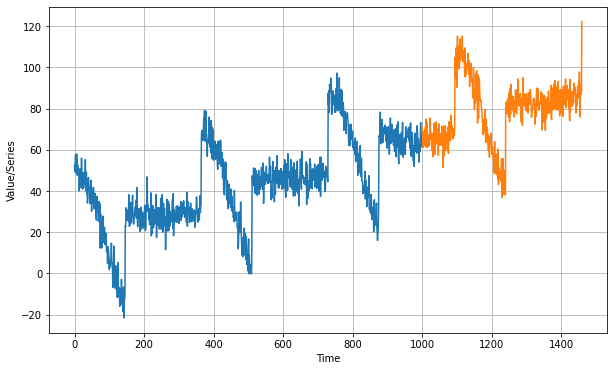

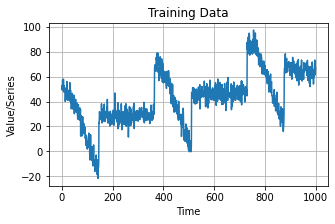

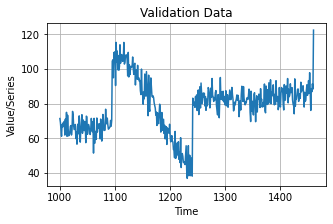

In [12]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10,6))
plot_series(time_train, x_train)
plot_series(time_valid,x_valid)
plt.show()

plt.figure(figsize=(5, 3))
plt.title("Training Data")
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(5, 3))
plt.title("Validation Data")
plot_series(time_valid, x_valid)
plt.show()

#Naive Forcast

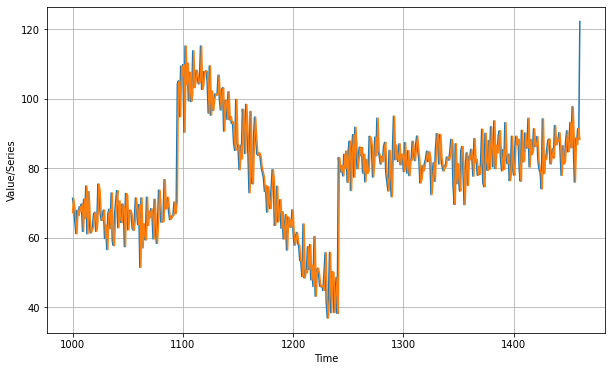

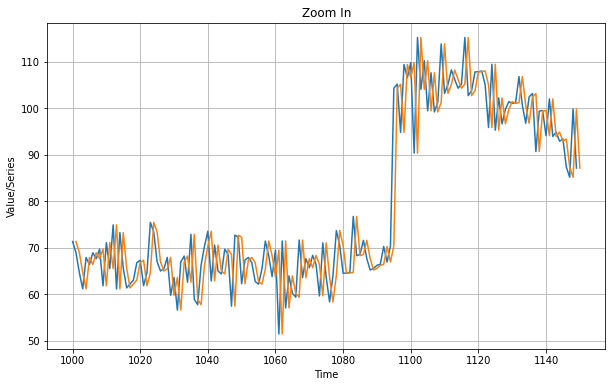

In [14]:
#one time period shift
naive_forecast = series[split_time - 1:-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
#Zoom in on the start of validation period
plt.figure(figsize=(10, 6))
plt.title("Zoom In")
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

The naive forecast lags 1 step behind the time series.

Let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period

In [22]:
print('MSE: ', end = '')
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print('MAE: ', end = '')
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

MSE: 61.827534
MAE: 5.937908


That's our baseline, now let's try a moving average:

In [23]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

MSE: 106.674576
MAE: 7.142419


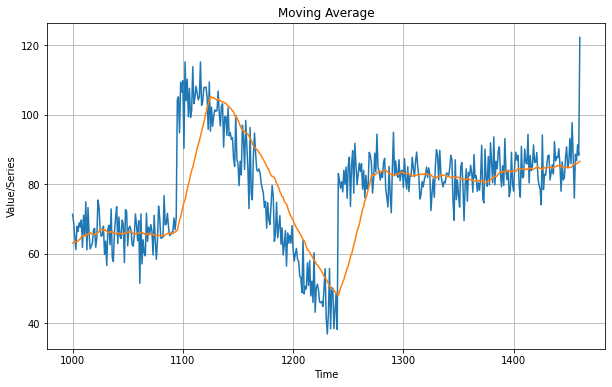

In [25]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plt.title("Moving Average")
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
print('MSE: ', end = '')
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print('MAE: ', end = '')
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t.

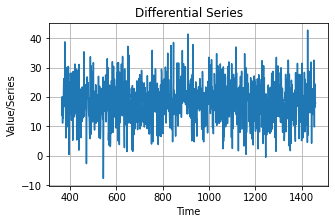

In [29]:
#Technique is differencing
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(5, 3))
plt.title("Differential Series")
plot_series(diff_time, diff_series)
plt.show()

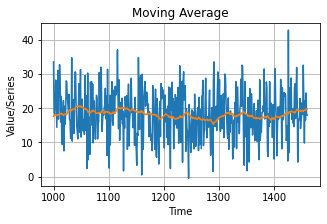

In [34]:
#the trend and seasonality seem to be gone, so now we can use the moving average
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(5, 3))
plt.title("Moving Average")
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)

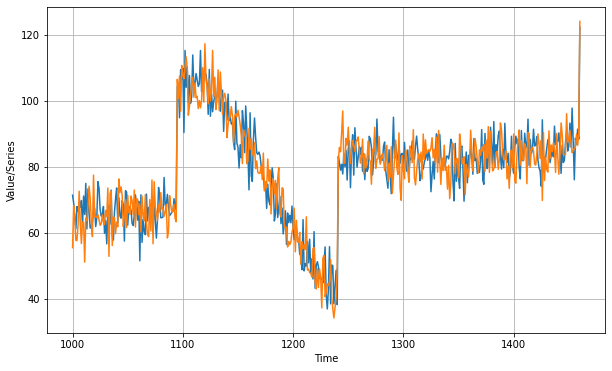

MSE: 52.973663
MAE: 5.839311


In [36]:
#let's bring back the trend and seasonality by adding the past values from t – 365:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()
print('MSE: ', end = '')
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print('MAE: ', end = '')
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

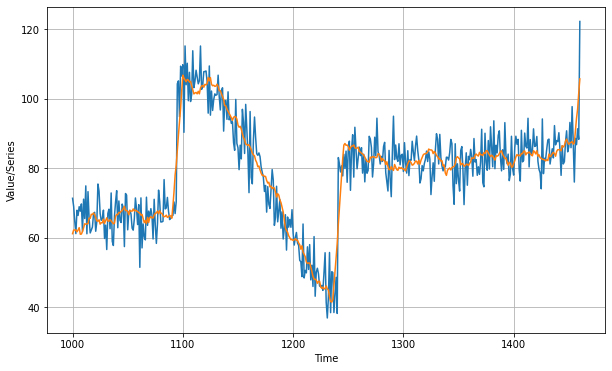

MSE: 33.452263
MAE: 4.569442


In [37]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()
print('MSE: ', end = '')
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print('MAE: ', end = '')
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

#Week 1 Excercise
Create and predict synthetic data, to enhance your learning experience. 

In [38]:
import tensorflow as tf
print(tf.__version__)

# EXPECTED OUTPUT
# 2.0.0-beta1 (or later)


2.4.1


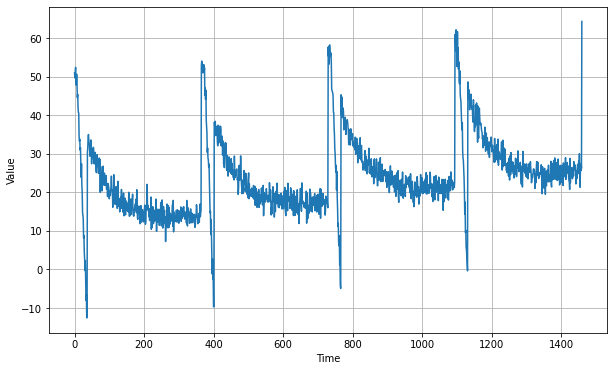

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# Chart as in the screencast. First should have 5 distinctive 'peaks'

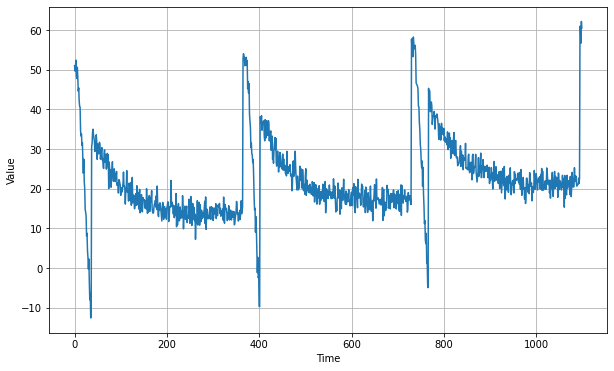

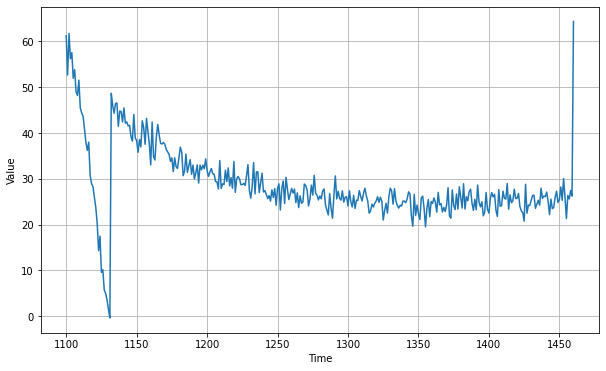

In [46]:
split_time = 1100# YOUR CODE HERE
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# EXPECTED OUTPUT
# Chart WITH 4 PEAKS between 50 and 65 and 3 troughs between -12 and 0
# Chart with 2 Peaks, first at slightly above 60, last at a little more than that, should also have a single trough at about 0

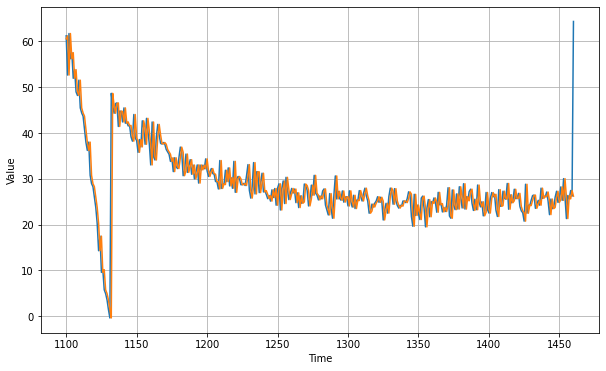

In [61]:
naive_forecast = series[split_time - 1:-1]#YOUR CODE HERE
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

# Expected output: Chart similar to above, but with forecast overlay

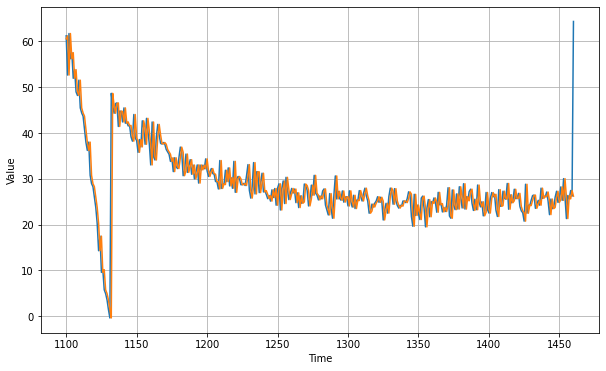

In [66]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, end = 1250)
plot_series(time_valid, naive_forecast, end = 1250)

# EXPECTED - Chart with X-Axis from 1100-1250 and Y Axes with series value and projections. Projections should be time stepped 1 unit 'after' series

In [67]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())# YOUR CODE HERE
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())# YOUR CODE HERE
# Expected Output
# 19.578304
# 2.6011968

19.578306
2.6011972


In [68]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  # YOUR CODE HERE
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

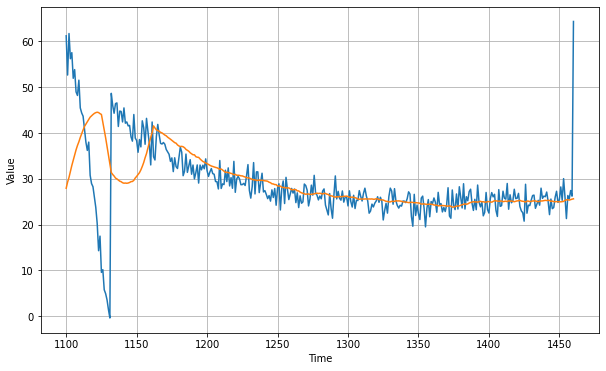

In [71]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]# (YOUR CODE HERE)[# YOUR CODE HERE]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
    
# EXPECTED OUTPUT
# CHart with time series from 1100->1450+ on X
# Time series plotted
# Moving average plotted over it

In [72]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())# (YOUR CODE HERE)
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())# YOUR CODE HERE)
# EXPECTED OUTPUT
# 65.786224
# 4.3040023

65.78622
4.3040023


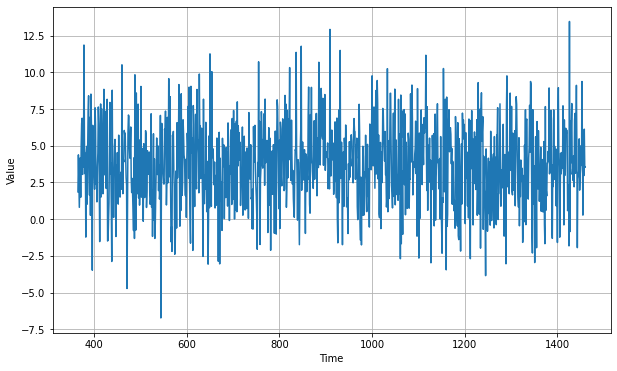

In [73]:
diff_series = (series[365:] - series[:-365])# YOUR CODE HERE)
diff_time = time[365:]# YOUR CODE HERE

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()
    
# EXPECETED OUTPUT: CHart with diffs

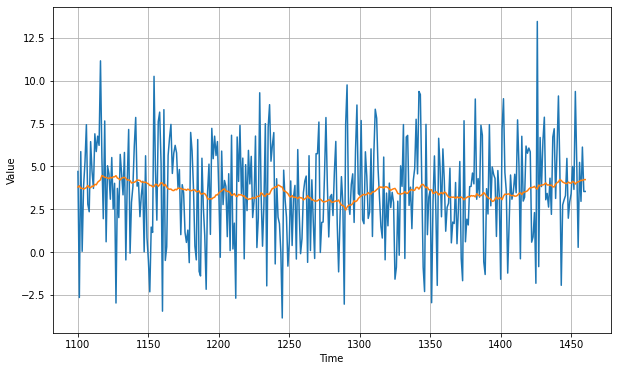

In [75]:
diff_moving_avg =  moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]# YOUR CODE HERE

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])# YOUR CODE HERE)
plot_series(time_valid, diff_moving_avg)# YOUR CODE HERE)
plt.show()
            
# Expected output. Diff chart from 1100->1450 +
# Overlaid with moving average

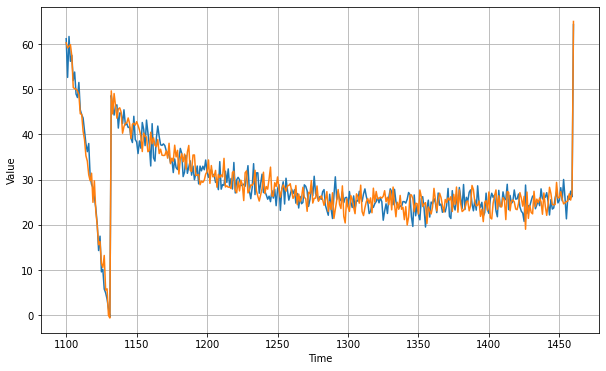

In [78]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg # YOUR CODE HERE

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # YOUR CODE HERE)
plot_series(time_valid, diff_moving_avg_plus_past) # YOUR CODE HERE)
plt.show()
# Expected output: Chart from 1100->1450+ on X. Same chart as earlier for time series, but projection overlaid looks close in value to it

In [79]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())# YOUR CODE HERE)
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())# YOUR CODE HERE)
# EXPECTED OUTPUT
# 8.498155
# 2.327179

8.498155
2.327179


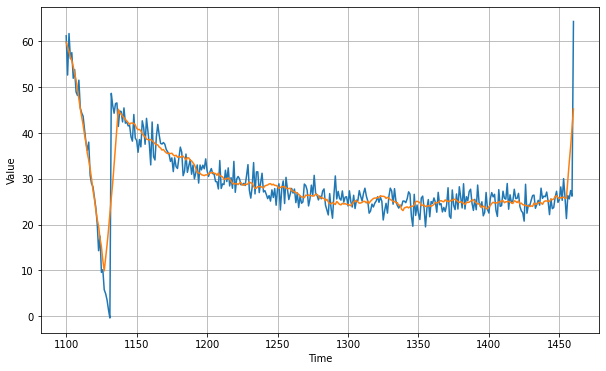

In [80]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg # YOUR CODE HERE

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # YOUR CODE HERE)
plot_series(time_valid, diff_moving_avg_plus_smooth_past) # YOUR CODE HERE)
plt.show()
# Expected output: Chart from 1100->1450+ on X. Same chart as earlier for time series, but projection overlaid looks close in value to it

In [81]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())# YOUR CODE HERE)
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())# YOUR CODE HERE)
# EXPECTED OUTPUT
# 12.527958
# 2.2034433

12.527958
2.2034435
